<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from sklearn.metrics import f1_score
import graphviz
from sklearn import tree

import pandas as pd
import numpy as np
import pyodbc
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression, RANSACRegressor, Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import time
from sklearn import neural_network

import warnings
warnings.filterwarnings('ignore') 

from sqlalchemy import create_engine, event
from sqlalchemy.exc import IntegrityError
from pandas.tseries.offsets import MonthEnd

from sklearn import tree
import pylab as pl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier     #big 99 / 56   #small 99 / 56
from sklearn.linear_model import LogisticRegression     #big 44 / 44 
from sklearn.ensemble import GradientBoostingClassifier #big 49 / 47
from sklearn.ensemble import BaggingClassifier          #big 98 / 56
from sklearn.ensemble import AdaBoostClassifier         #big 49 / 48

from sklearn.svm import SVC                            
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.patches as mpatches

папка_хранения_результатов=r'E:\Jupyter\ION'
os.chdir(папка_хранения_результатов)

In [50]:
# Для нейронки ILYA
%matplotlib inline 


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

# Количество классов
nb_classes = 11

#Выставляем размер для графиков
plt.rcParams["figure.figsize"] = (20,10)

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [51]:
def рисовалка(ds):
    col=ds.columns

    plt.rcParams["figure.figsize"] = (20,10)

    for it in range(11):

        samp=ds.iloc[500000*it:500000*(it+1)]

        samp_chn_time=[]
        samp_chn_sign=[]

        for open_chn in range (11):
            samp_chn_time.append(list(samp.loc[samp[col[2]]==open_chn,col[0]]))
            samp_chn_sign.append(list(samp.loc[samp[col[2]]==open_chn,col[1]]))

        plt.plot(samp_chn_time[0], samp_chn_sign[0],'r.',linestyle="None",label='0')

        plt.plot(samp_chn_time[1],samp_chn_sign[1],"g.",linestyle="None",label='1')

        plt.plot(samp_chn_time[2],samp_chn_sign[2],"b.",linestyle="None",label='2')

        plt.plot(samp_chn_time[3],samp_chn_sign[3],'tab:orange',marker=".",linestyle="None",label='3')

        plt.plot(samp_chn_time[4],samp_chn_sign[4],"y.",linestyle="None",label='4')

        plt.plot(samp_chn_time[5], samp_chn_sign[5],"m.",linestyle="None",label='5')

        plt.plot(samp_chn_time[6],samp_chn_sign[6],"k.",linestyle="None",label='6')

        plt.plot(samp_chn_time[7],samp_chn_sign[7],"c.",linestyle="None",label='7')

        plt.plot(samp_chn_time[8],samp_chn_sign[8],'tab:gray',marker=".",linestyle="None",label='8')

        plt.plot(samp_chn_time[9],samp_chn_sign[9],"tab:brown",marker=".",linestyle="None",label='9')

        plt.plot(samp_chn_time[10],samp_chn_sign[10],"tab:purple",marker=".",linestyle="None",label='10')

    #     plt.legend([chnl_0, chnl_1,chnl_2,chnl_3,chnl_4,chnl_5,chnl_6,chnl_7,chnl_8,chnl_9,chnl_10], 
    #                ["0",'1', '2',"3","4","5","6","7","8","9","10"])


        red_patch = mpatches.Patch(color='red', label='0')
        green_patch = mpatches.Patch(color='green', label='1')
        blue_patch = mpatches.Patch(color='blue', label='2')
        orang_patch = mpatches.Patch(color='orange', label='3')
        yel_patch = mpatches.Patch(color='yellow', label='4')
        mag_patch = mpatches.Patch(color='magenta', label='5')
        blc_patch = mpatches.Patch(color='black', label='6')
        cyan_patch = mpatches.Patch(color='cyan', label='7')
        gray_patch = mpatches.Patch(color='gray', label='8')
        brwn_patch = mpatches.Patch(color='brown', label='9')
        purp_patch = mpatches.Patch(color='purple', label='10')


        plt.legend(handles=[red_patch,green_patch,blue_patch,orang_patch,yel_patch,
                           mag_patch,blc_patch,cyan_patch,gray_patch,brwn_patch,purp_patch])

In [52]:
test = pd.read_csv(r'E:\Jupyter\ION\test_clean.csv')
test['open_channels']=0
test['layer']=1
train = pd.read_csv(r'E:\Jupyter\ION\train_clean.csv')
train['layer']=0
train.head()

ds=pd.concat([train])
ds=ds.set_index('time')
ds['open_channels']=ds['open_channels'].astype('int16')

ds['layer']=ds['layer'].astype('int16') #для экономии памяти
ds['signal']=ds['signal'].astype('float32') #для экономии памяти


ds['signal']=ds['signal']*10.0+100.0 #преобразование для расчета отношений

In [53]:
train_set=ds[((ds.index>=200) & (ds.index<=250))]            
test_set=ds[((ds.index>=450) & (ds.index<=500))]

test_set['open_channels_pr']=-99
train_set['open_channels_pr']=-99

lag=8 # определяет число точек, поиграй с увеличением/ уменьшением числа
train_set[f'signal_{0}']=train_set['signal']
for i in range(1,lag):
    train_set[f'signal_p{i}']=train_set['signal'].shift(periods=i)
    train_set[f'signal_m{i}']=train_set['signal'].shift(periods=-i)
    
train_set=train_set.dropna()

test_set[f'signal_{0}']=test_set['signal']
for i in range(1,lag):
    test_set[f'signal_p{i}']=test_set['signal'].shift(periods=i)
    test_set[f'signal_m{i}']=test_set['signal'].shift(periods=-i)
    
test_set=test_set.dropna()


test_set=test_set[test_set.open_channels>3]
train_set=train_set[train_set.open_channels>3]


In [54]:
#=================================================#
train_set['mean']=train_set.iloc[:,3:].mean(axis=1)
train_set['min']=train_set.iloc[:,3:].min(axis=1)
train_set['max']=train_set.iloc[:,3:].max(axis=1)

train_set['s/min']=train_set['signal']/train_set['min']
train_set['s/max']=train_set['signal']/train_set['max']
train_set['s/mean']=train_set['signal']/train_set['mean']

train_set['s/min'][train_set['s/min']>100]=100
train_set['s/min'][train_set['s/min']<-100]=-100

train_set['s/max'][train_set['s/max']>100]=100
train_set['s/max'][train_set['s/max']<-100]=-100

train_set['s/mean'][train_set['s/mean']>100]=100
train_set['s/mean'][train_set['s/mean']<-100]=-100

train_set['s/min'][train_set['s/min'].isna()]=1000
train_set['s/max'][train_set['s/max'].isna()]=1000
train_set['s/mean'][train_set['s/mean'].isna()]=1000
#==================================================#
test_set['mean']=test_set.iloc[:,3:].mean(axis=1)
test_set['min']=test_set.iloc[:,3:].min(axis=1)
test_set['max']=test_set.iloc[:,3:].max(axis=1)

test_set['s/min']=test_set['signal']/test_set['min']
test_set['s/max']=test_set['signal']/test_set['max']
test_set['s/mean']=test_set['signal']/test_set['mean']

test_set['s/min'][test_set['s/min']>100]=100
test_set['s/min'][test_set['s/min']<-100]=-100

test_set['s/max'][test_set['s/max']>100]=100
test_set['s/max'][test_set['s/max']<-100]=-100


test_set['s/mean'][test_set['s/mean']>100]=100
test_set['s/mean'][test_set['s/mean']<-100]=-100

test_set['s/min'][test_set['s/min'].isna()]=1000
test_set['s/max'][test_set['s/max'].isna()]=1000
test_set['s/mean'][test_set['s/mean'].isna()]=1000


In [55]:
train_set['s_dop1']=(train_set.signal_p1*train_set.signal_m1)**(1/2)
test_set['s_dop1']=(test_set.signal_p1*test_set.signal_m1)**(1/2)
train_set['s_dop2']=(train_set.signal_p2*train_set.signal_m2)**(1/2)
test_set['s_dop2']=(test_set.signal_p2*test_set.signal_m2)**(1/2)
train_set['s_dop3']=(train_set.signal_p3*train_set.signal_m3)**(1/2)
test_set['s_dop3']=(test_set.signal_p3*test_set.signal_m3)**(1/2)




In [56]:
#определение границ классов
upBound_9=np.quantile(train_set[train_set.open_channels==9].signal,0.99)
downBound_9=np.quantile(train_set[train_set.open_channels==9].signal,0.01)
downBound_10=np.quantile(train_set[train_set.open_channels==10].signal,0.01)

In [57]:
#обрезаем по границу 9 класса
train_set=train_set[train_set.signal>=downBound_9]
test_set=test_set[test_set.signal>=downBound_9]
#меняем класс на 1-10 / 0 - все остальные
train_set.loc[:,'open_channels']=(train_set['open_channels']==10)*1
test_set.loc[:,'open_channels']=(test_set['open_channels']==10)*1

In [58]:
#определяем классы исходя из границ
test_set.loc[:,'open_channels_pr']=-99
train_set.loc[:,'open_channels_pr']=-99
#если выше границы 9 класса, то 10 (1)
train_set.loc[train_set.signal>=upBound_9,'open_channels_pr']=1
test_set.loc[test_set.signal>=upBound_9,'open_channels_pr']=1
#если ниже границы 10 класса, то 9 (0)
train_set.loc[train_set.signal<downBound_10,'open_channels_pr']=0
test_set.loc[test_set.signal<downBound_10,'open_channels_pr']=0

print(len(train_set),'длина теста',sum(test_set.open_channels_pr!=-99),'число_автоматически_определенных')

117278 длина теста 92774 число_автоматически_определенных


In [59]:
#классифицируем обрезанные данные
train_set2=train_set[train_set.open_channels_pr==-99]
test_set2=test_set[test_set.open_channels_pr==-99]

In [60]:


# Нормализуем для нейронки
X_train=train_set2.iloc[:,4:]
Y_train=train_set2['open_channels']

X_test=test_set2[train_set2.columns].iloc[:,4:]
Y_test=test_set2['open_channels']

X_train = X_train/1000
X_test  = X_test/1000

#Преобразуем ответы в формат вектора
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(Y_train)
Y_trainN = encoder.transform(Y_train)

encoder.fit(Y_test)
Y_testN = encoder.transform(Y_test)

#Y_trainN=utils.to_categorical(Y_trainN,11)
#Y_testN = utils.to_categorical(Y_testN,11)

#Y_trainN=Y_trainN.astype('int16')
#Y_testN=Y_testN.astype('int16')

In [13]:
X_train

,signal_0,signal_p1,signal_m1,signal_p2,signal_m2,signal_p3,signal_m3,signal_p4,signal_m4,signal_p5,...,signal_m7,mean,min,max,s/min,s/max,s/mean,s_dop1,s_dop2,s_dop3
time,,,,,,,,,,,,,,,,,,,,,
200.0007,0.165489,0.176610,0.160989,0.174194,0.166409,0.173541,0.167583,0.169278,0.168535,0.167712,...,0.173647,0.149219,-0.099,0.178474,-0.001672,0.000927,0.001109,0.168619,0.170257,0.170536
200.0008,0.160989,0.165489,0.166409,0.176610,0.167583,0.174194,0.168535,0.173541,0.178474,0.169278,...,0.171249,0.153752,-0.099,0.178474,-0.001626,0.000902,0.001047,0.165948,0.172037,0.171341
200.0017,0.165567,0.168979,0.175586,0.171249,0.172263,0.173647,0.170628,0.174129,0.171938,0.178474,...,0.161760,0.153953,-0.099,0.178474,-0.001672,0.000928,0.001075,0.172251,0.171755,0.172131
200.0024,0.161760,0.169313,0.170639,0.172597,0.169769,0.171938,0.167709,0.170628,0.168166,0.172263,...,0.180359,0.153278,-0.099,0.180359,-0.001634,0.000897,0.001055,0.169975,0.171177,0.169810
200.0032,0.163300,0.180359,0.170070,0.167969,0.159741,0.167192,0.153943,0.168166,0.165773,0.167709,...,0.159462,0.148498,-0.099,0.180359,-0.001649,0.000905,0.001100,0.175139,0.163803,0.160431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249.9739,0.161015,0.137036,0.133069,0.130074,0.141368,0.114697,0.150786,0.139514,0.141402,0.121889,...,0.131624,0.121093,-0.099,0.161015,-0.001626,0.001000,0.001330,0.135038,0.135603,0.131509
249.9787,0.161659,0.134210,0.141467,0.129771,0.136082,0.131248,0.132838,0.114149,0.155569,0.119487,...,0.154823,0.123427,-0.099,0.161659,-0.001633,0.001000,0.001310,0.137791,0.132889,0.132041
249.9884,0.162379,0.152338,0.154938,0.154327,0.155138,0.141806,0.141060,0.150438,0.147794,0.143959,...,0.160603,0.138704,-0.099,0.174583,-0.001640,0.000930,0.001171,0.153633,0.154732,0.141433


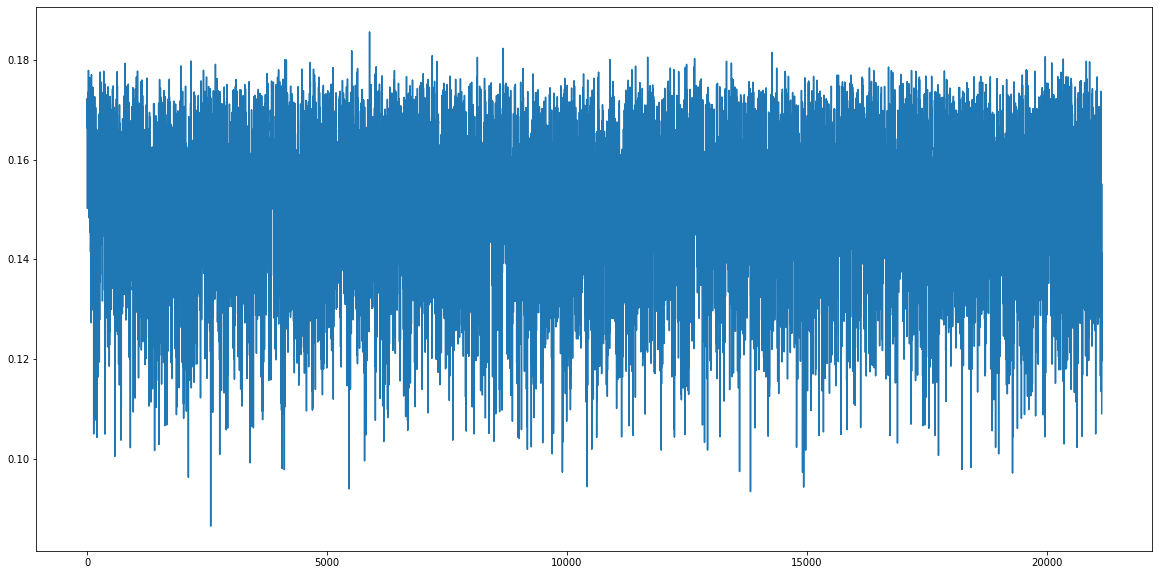

In [61]:
graf = X_train.loc[X_train.index[:], 'signal_m2'].tolist()
plt.plot(graf)
plt.show()
#graf = ds.loc[ds.index[:], 'signal'].tolist()
#plt.plot(graf)
#plt.show()


In [64]:
# 89%  12 -> 1 48 -24 - 1
model = Sequential()
model.add(Dense(48, input_dim=24, kernel_initializer='normal', activation='relu'))
model.add(Dense(24, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
#Load best
from keras.models import load_model
model = load_model(r'E:\Jupyter\ION\testb5.hdf5')

checkpointer = ModelCheckpoint(filepath="testb6.hdf5", verbose=1, save_best_only=True)
history = model.fit(X_train, Y_trainN, 
          nb_epoch = 400, 
          batch_size = 16, 
          verbose=1, 
          validation_data=(X_test, Y_testN),
          callbacks=[checkpointer],
          #callbacks=[reduce_lr, checkpointer],
          shuffle=True)

Train on 21145 samples, validate on 20148 samples
Epoch 1/400
21145/21145 [==============================] - 5s 235us/step - loss: 0.3565 - accuracy: 0.8498 - val_loss: 0.3365 - val_accuracy: 0.8549

Epoch 00001: val_loss improved from inf to 0.33645, saving model to testb6.hdf5
Epoch 2/400
21145/21145 [==============================] - 5s 239us/step - loss: 0.3475 - accuracy: 0.8505 - val_loss: 0.3405 - val_accuracy: 0.8555

Epoch 00002: val_loss did not improve from 0.33645
Epoch 3/400
21145/21145 [==============================] - 5s 229us/step - loss: 0.3487 - accuracy: 0.8520 - val_loss: 0.3884 - val_accuracy: 0.8291

Epoch 00003: val_loss did not improve from 0.33645
Epoch 4/400
21145/21145 [==============================] - 5s 228us/step - loss: 0.3489 - accuracy: 0.8507 - val_loss: 0.3407 - val_accuracy: 0.8518

Epoch 00004: val_loss did not improve from 0.33645
Epoch 5/400
21145/21145 [==============================] - 5s 225us/step - loss: 0.3490 - accuracy: 0.8509 - val_loss


Epoch 00040: val_loss did not improve from 0.33561
Epoch 41/400
21145/21145 [==============================] - 5s 230us/step - loss: 0.3501 - accuracy: 0.8497 - val_loss: 0.3715 - val_accuracy: 0.8383

Epoch 00041: val_loss did not improve from 0.33561
Epoch 42/400
21145/21145 [==============================] - 5s 247us/step - loss: 0.3452 - accuracy: 0.8547 - val_loss: 0.3537 - val_accuracy: 0.8490

Epoch 00042: val_loss did not improve from 0.33561
Epoch 43/400
21145/21145 [==============================] - 5s 234us/step - loss: 0.3458 - accuracy: 0.8513 - val_loss: 0.3457 - val_accuracy: 0.8523

Epoch 00043: val_loss did not improve from 0.33561
Epoch 44/400
21145/21145 [==============================] - 5s 245us/step - loss: 0.3440 - accuracy: 0.8519 - val_loss: 0.3430 - val_accuracy: 0.8541

Epoch 00044: val_loss did not improve from 0.33561
Epoch 45/400
21145/21145 [==============================] - 5s 238us/step - loss: 0.3478 - accuracy: 0.8539 - val_loss: 0.3393 - val_accurac

21145/21145 [==============================] - 5s 232us/step - loss: 0.3482 - accuracy: 0.8524 - val_loss: 0.3360 - val_accuracy: 0.8553

Epoch 00121: val_loss did not improve from 0.33534
Epoch 122/400
21145/21145 [==============================] - 5s 244us/step - loss: 0.3429 - accuracy: 0.8551 - val_loss: 0.3364 - val_accuracy: 0.8542

Epoch 00122: val_loss did not improve from 0.33534
Epoch 123/400
21145/21145 [==============================] - 5s 236us/step - loss: 0.3440 - accuracy: 0.8522 - val_loss: 0.3428 - val_accuracy: 0.8543

Epoch 00123: val_loss did not improve from 0.33534
Epoch 124/400
21145/21145 [==============================] - 5s 226us/step - loss: 0.3414 - accuracy: 0.8539 - val_loss: 0.3371 - val_accuracy: 0.8560

Epoch 00124: val_loss did not improve from 0.33534
Epoch 125/400
21145/21145 [==============================] - 5s 234us/step - loss: 0.3436 - accuracy: 0.8544 - val_loss: 0.3374 - val_accuracy: 0.8547

Epoch 00125: val_loss did not improve from 0.33534

21145/21145 [==============================] - 5s 218us/step - loss: 0.3413 - accuracy: 0.8550 - val_loss: 0.3349 - val_accuracy: 0.8565

Epoch 00201: val_loss did not improve from 0.33489
Epoch 202/400
21145/21145 [==============================] - 5s 218us/step - loss: 0.3429 - accuracy: 0.8529 - val_loss: 0.3351 - val_accuracy: 0.8560

Epoch 00202: val_loss did not improve from 0.33489
Epoch 203/400
21145/21145 [==============================] - 5s 218us/step - loss: 0.3439 - accuracy: 0.8515 - val_loss: 0.3421 - val_accuracy: 0.8523

Epoch 00203: val_loss did not improve from 0.33489
Epoch 204/400
21145/21145 [==============================] - 5s 219us/step - loss: 0.3436 - accuracy: 0.8533 - val_loss: 0.3362 - val_accuracy: 0.8549

Epoch 00204: val_loss did not improve from 0.33489
Epoch 205/400
21145/21145 [==============================] - 5s 218us/step - loss: 0.3423 - accuracy: 0.8554 - val_loss: 0.3801 - val_accuracy: 0.8334

Epoch 00205: val_loss did not improve from 0.33489

21145/21145 [==============================] - 5s 216us/step - loss: 0.3405 - accuracy: 0.8537 - val_loss: 0.3368 - val_accuracy: 0.8544

Epoch 00241: val_loss did not improve from 0.33437
Epoch 242/400
21145/21145 [==============================] - 5s 218us/step - loss: 0.3418 - accuracy: 0.8567 - val_loss: 0.3525 - val_accuracy: 0.8485

Epoch 00242: val_loss did not improve from 0.33437
Epoch 243/400
21145/21145 [==============================] - 5s 217us/step - loss: 0.3404 - accuracy: 0.8529 - val_loss: 0.3349 - val_accuracy: 0.8562

Epoch 00243: val_loss did not improve from 0.33437
Epoch 244/400
21145/21145 [==============================] - 5s 219us/step - loss: 0.3421 - accuracy: 0.8537 - val_loss: 0.3406 - val_accuracy: 0.8548

Epoch 00244: val_loss did not improve from 0.33437
Epoch 245/400
21145/21145 [==============================] - 5s 216us/step - loss: 0.3445 - accuracy: 0.8517 - val_loss: 0.3453 - val_accuracy: 0.8531

Epoch 00245: val_loss did not improve from 0.33437

21145/21145 [==============================] - 5s 217us/step - loss: 0.3436 - accuracy: 0.8528 - val_loss: 0.3416 - val_accuracy: 0.8530

Epoch 00321: val_loss did not improve from 0.33437
Epoch 322/400
21145/21145 [==============================] - 5s 217us/step - loss: 0.3415 - accuracy: 0.8560 - val_loss: 0.3355 - val_accuracy: 0.8556

Epoch 00322: val_loss did not improve from 0.33437
Epoch 323/400
21145/21145 [==============================] - 5s 217us/step - loss: 0.3394 - accuracy: 0.8554 - val_loss: 0.3367 - val_accuracy: 0.8552

Epoch 00323: val_loss did not improve from 0.33437
Epoch 324/400
21145/21145 [==============================] - 5s 215us/step - loss: 0.3403 - accuracy: 0.8531 - val_loss: 0.4775 - val_accuracy: 0.8185

Epoch 00324: val_loss did not improve from 0.33437
Epoch 325/400
21145/21145 [==============================] - 5s 220us/step - loss: 0.3401 - accuracy: 0.8559 - val_loss: 0.3358 - val_accuracy: 0.8559

Epoch 00325: val_loss did not improve from 0.33437

In [1]:
# График обучени
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [75]:
#Load best
from keras.models import load_model
model = load_model(r'E:\Jupyter\ION\testb6.hdf5')
#Предсказываем
predict=model.predict(X_test).round()


In [76]:
#Выбор лучшего
test_set2['open_channels_pr']=predict

train_set.loc[train_set2.index,'open_channels_pr']=train_set2['open_channels_pr']
test_set.loc[test_set2.index,'open_channels_pr']=test_set2['open_channels_pr']

print(f1_score(test_set.open_channels,test_set.open_channels_pr, average='binary',))


0.8900545038973217


In [ ]:
Нейронка енд

In [ ]:
#классифицируем обрезанные данные
train_set2=train_set[train_set.open_channels_pr==-99]
test_set2=test_set[test_set.open_channels_pr==-99]

clf=RandomForestClassifier(n_jobs=-1,n_estimators=400,max_depth=7,max_features=7)

X_train=train_set2.iloc[:,4:]
Y_train=train_set2['open_channels']

X_test=test_set2[train_set2.columns].iloc[:,4:]
Y_test=test_set2['open_channels']

clf.fit(X_train, Y_train)

Y_predict=clf.predict(X_test).round()
test_set2['open_channels_pr']=Y_predict

#Y_predict=clf.predict(X_train).round()
#train_set2['open_channels_pr']=Y_predict

train_set.loc[train_set2.index,'open_channels_pr']=train_set2['open_channels_pr']
test_set.loc[test_set2.index,'open_channels_pr']=test_set2['open_channels_pr']


print(f1_score(test_set.open_channels,test_set.open_channels_pr, average='binary',))



